# Identifying dog breeds

DS 4002


## Preprocessing Data

In [ ]:
import sys
import sklearn
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from functools import partial
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras

np.random.seed(42)
tf.random.set_seed(42)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
# Install PyDrive
!pip install PyDrive

#Import modules
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

#Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#Get the Shareable link
#Ex link : https://drive.google.com/file/d/1c7Ffo1Go1dtUpKcSWxdbdVyW4dfhEoUp/view?usp=sharing
downloaded = drive.CreateFile({'id':"15wJZnQrMxmgAspuAa8vyXIgWHL_uf1vu"})
downloaded.GetContentFile('dog_data.tar')

In [ ]:
!tar xf dog_data.tar


In [ ]:
from sklearn.datasets import load_files

from keras.preprocessing import image
from tqdm import tqdm # progress bar

train_data_dir = "/content/Images/"
test_data_dir = "/content/test/"
batch_size = 32;
# IMPORTANT: Depends on what pre-trained model you choose, you will need to change these dimensions accordingly
img_height = 32;
img_width = 32;

# Training Dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    labels='inferred',
    # label_mode="categorical",
    seed = 42,
    image_size= (img_height, img_width),
    batch_size = batch_size
)

# # Testing Dataset
# test_ds = tf.keras.preprocessing.image_dataset_from_directory(
#     test_data_dir,
#     labels='inferred',
#     # label_mode="categorical",
#     seed = 42,
#     image_size= (img_height, img_width),
#     batch_size = batch_size
# )

print("Training Classes:")
train_ds_class_names = dataset.class_names
print(train_ds_class_names)


Found 20580 files belonging to 120 classes.
Training Classes:
['n02085620-Chihuahua', 'n02085782-Japanese_spaniel', 'n02085936-Maltese_dog', 'n02086079-Pekinese', 'n02086240-Shih-Tzu', 'n02086646-Blenheim_spaniel', 'n02086910-papillon', 'n02087046-toy_terrier', 'n02087394-Rhodesian_ridgeback', 'n02088094-Afghan_hound', 'n02088238-basset', 'n02088364-beagle', 'n02088466-bloodhound', 'n02088632-bluetick', 'n02089078-black-and-tan_coonhound', 'n02089867-Walker_hound', 'n02089973-English_foxhound', 'n02090379-redbone', 'n02090622-borzoi', 'n02090721-Irish_wolfhound', 'n02091032-Italian_greyhound', 'n02091134-whippet', 'n02091244-Ibizan_hound', 'n02091467-Norwegian_elkhound', 'n02091635-otterhound', 'n02091831-Saluki', 'n02092002-Scottish_deerhound', 'n02092339-Weimaraner', 'n02093256-Staffordshire_bullterrier', 'n02093428-American_Staffordshire_terrier', 'n02093647-Bedlington_terrier', 'n02093754-Border_terrier', 'n02093859-Kerry_blue_terrier', 'n02093991-Irish_terrier', 'n02094114-Norfolk

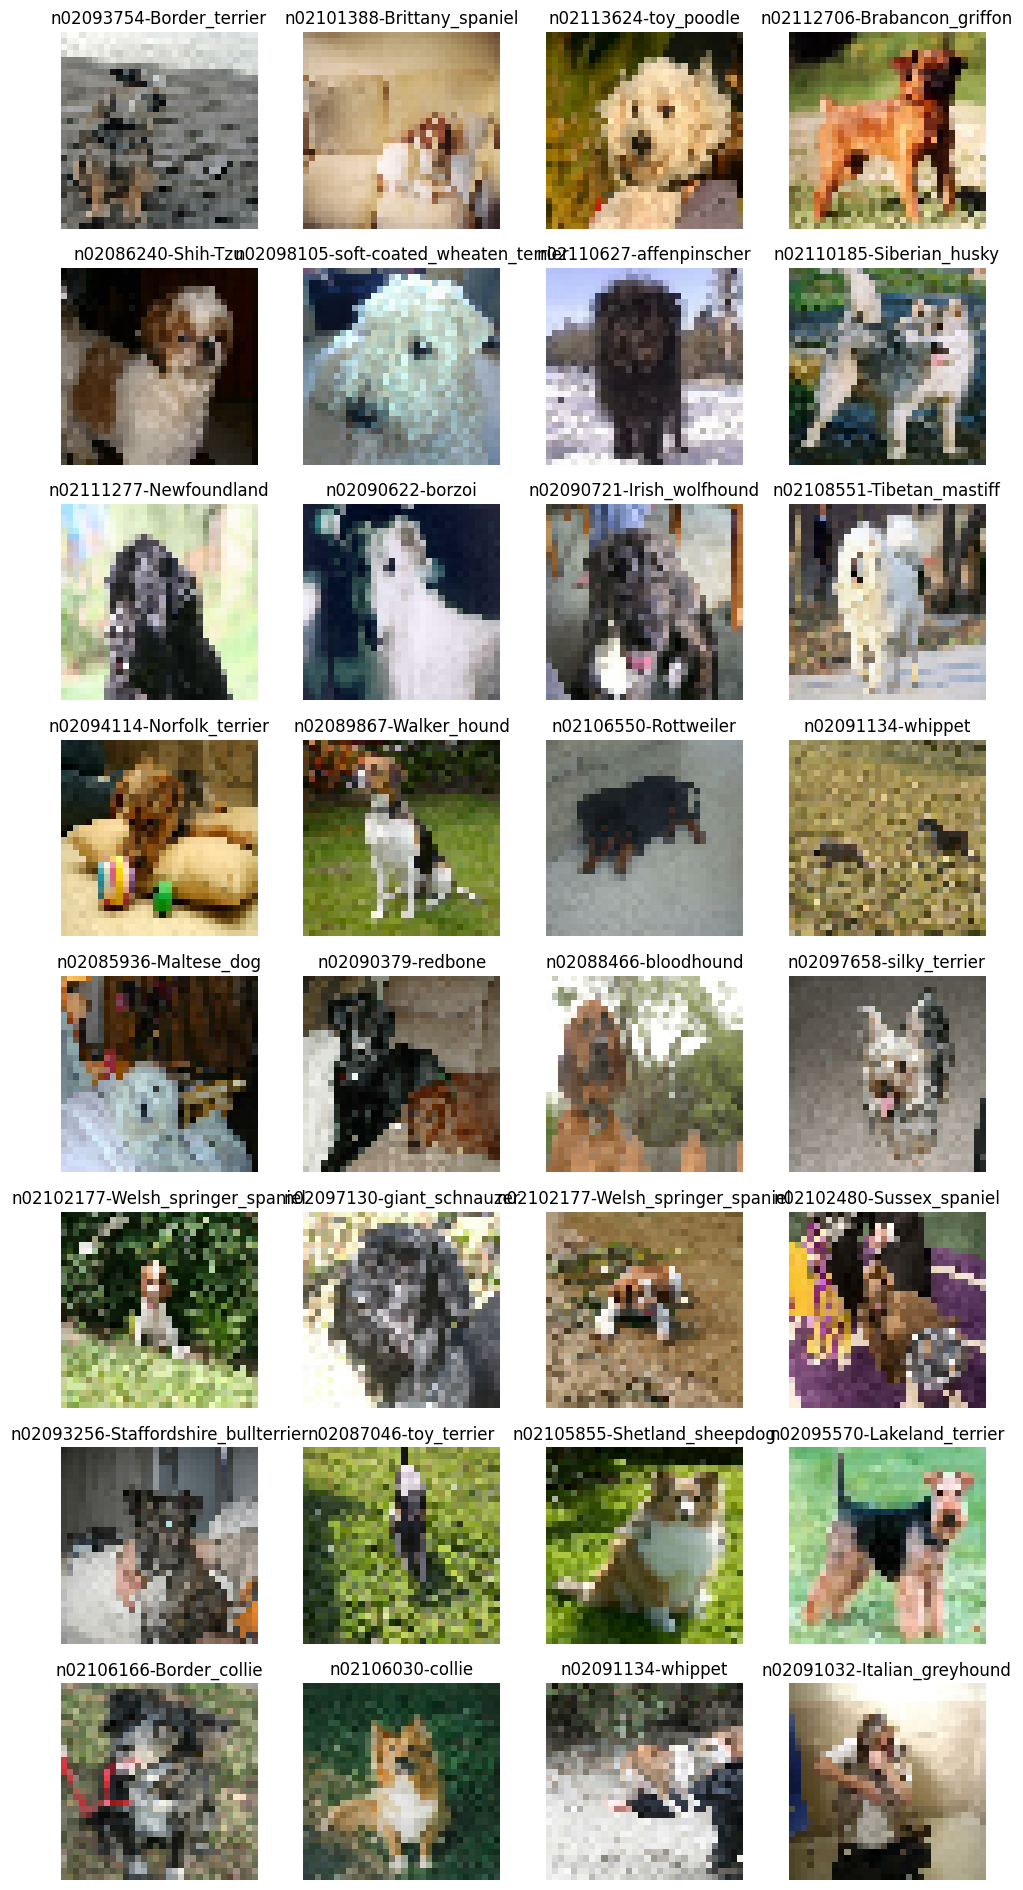

In [ ]:
n_rows = 8
n_cols = 4
plt.figure(figsize=(n_cols * 3, n_rows * 3))
for images, labels in dataset.take(1):
    for i in range (n_rows*n_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis('off')
        plt.title(train_ds_class_names[labels[i]], fontsize=12)
plt.subplots_adjust(wspace=.2, hspace=.2)


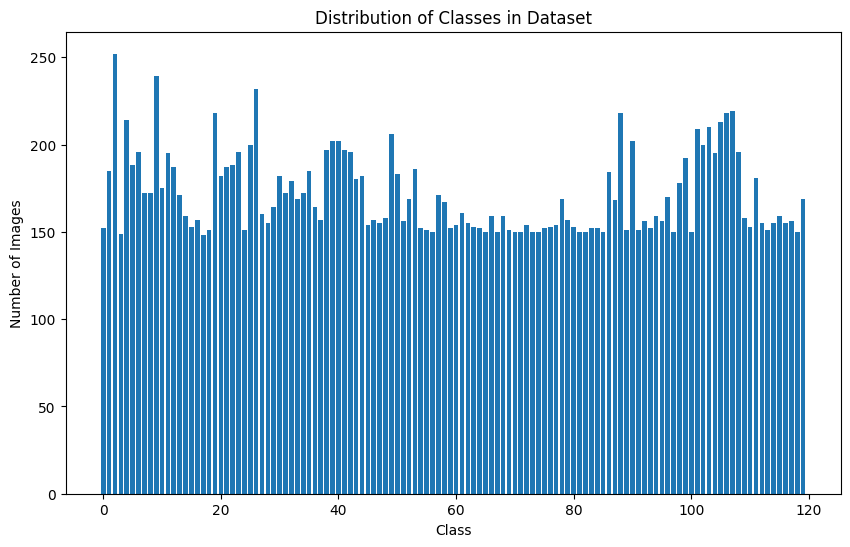

In [ ]:
import matplotlib.pyplot as plt

# Count the number of images in each class
class_counts = [0] * len(dataset.class_names)
for images, labels in dataset:
    for label in labels.numpy():
        class_counts[label] += 1

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.bar(range(len(class_counts)), class_counts)
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Distribution of Classes in Dataset')
plt.show()


In [ ]:
# Get class names from the dataset
class_names = dataset.class_names

# Create a list of tuples with class index and corresponding count
class_counts_with_indices = [(idx, count) for idx, count in enumerate(class_counts)]

# Sort the list based on count in descending order
class_counts_with_indices.sort(key=lambda x: x[1], reverse=True)

# Print top 5 classes with highest counts
print("Top 5 classes with highest counts:")
for i in range(10):
    idx, count = class_counts_with_indices[i]
    print(class_names[idx])
    # print(f"Class {idx}: {class_names[idx]} - {count} images")

print()

# Print top 5 classes with lowest counts
print("Top 5 classes with lowest counts:")
for i in range(-1, -6, -1):
    idx, count = class_counts_with_indices[i]
    print(f"Class {idx}: {class_names[idx]} - {count} images")


Top 5 classes with highest counts:
n02085936-Maltese_dog
n02088094-Afghan_hound
n02092002-Scottish_deerhound
n02112018-Pomeranian
n02090721-Irish_wolfhound
n02107683-Bernese_mountain_dog
n02111889-Samoyed
n02086240-Shih-Tzu
n02111500-Great_Pyrenees
n02111129-Leonberg

Top 5 classes with lowest counts:
Class 17: n02090379-redbone - 148 images
Class 3: n02086079-Pekinese - 149 images
Class 118: n02115913-dhole - 150 images
Class 100: n02110627-affenpinscher - 150 images
Class 97: n02109961-Eskimo_dog - 150 images


In [ ]:
# Determine the size of the train and test sets
size = len(dataset)
train_size = int(0.8 * size)
test_size = size - train_size

# Split the dataset into train and test sets
train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)



## Convolutional Neural Network (CNN)


In [ ]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, activation='relu', padding="SAME")

myModel = keras.models.Sequential([
    keras.layers.Conv2D(filters=64, kernel_size=(7, 7), input_shape=(img_width, img_height, 3), activation='relu', padding="same"),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=512),
    DefaultConv2D(filters=512),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Dense(units=256, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Flatten(),
    keras.layers.Dense(120, activation="softmax")
])
myModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        9472      
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 128)         0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 256)         2

In [ ]:
myOptimizer = tf.keras.optimizers.Nadam(learning_rate=0.001)
myLoss = 'sparse_categorical_crossentropy'
myMetrics = ['accuracy']
myModel.compile(loss= myLoss, optimizer = myOptimizer, metrics = myMetrics)

history = myModel.fit(train_dataset, validation_data=test_dataset, epochs = 10)

Epoch 1/10
515/515 [==============================] - 47s 71ms/step - loss: 4.8091 - accuracy: 0.0101 - val_loss: 4.7847 - val_accuracy: 0.0120
Epoch 2/10
515/515 [==============================] - 36s 70ms/step - loss: 4.7841 - accuracy: 0.0097 - val_loss: 4.7847 - val_accuracy: 0.0120
Epoch 3/10
515/515 [==============================] - 41s 79ms/step - loss: 4.7816 - accuracy: 0.0118 - val_loss: 4.7848 - val_accuracy: 0.0117
Epoch 4/10
515/515 [==============================] - 38s 73ms/step - loss: 4.7803 - accuracy: 0.0124 - val_loss: 4.7849 - val_accuracy: 0.0115
Epoch 5/10
515/515 [==============================] - 37s 71ms/step - loss: 4.7805 - accuracy: 0.0113 - val_loss: 4.7849 - val_accuracy: 0.0117
Epoch 6/10
515/515 [==============================] - 37s 71ms/step - loss: 4.7800 - accuracy: 0.0121 - val_loss: 4.7855 - val_accuracy: 0.0117
Epoch 7/10
515/515 [==============================] - 37s 72ms/step - loss: 4.8008 - accuracy: 0.0120 - val_loss: 4.7856 - val_accuracy:

In [ ]:
y_true = []
y_pred = []
missclassified = []

for x_batch, y_batch in test_dataset:
    batch_predictions = myModel.predict(x_batch)
    batch_predictions = np.argmax(batch_predictions, axis=-1)
    y_pred.extend(batch_predictions)
    y_true.extend(y_batch)
    for i in range(len(y_batch)):
      if batch_predictions[i] != y_batch[i]:
        missclassified.append((x_batch[i], y_batch[i]))


y_true = np.array(y_true)
y_pred = np.array(y_pred)

cf_matrix = confusion_matrix(y_true, y_pred)

print("Confusion Matrix:")
print(cf_matrix)
accuracy = accuracy_score(y_true, y_pred)
print(accuracy)
print(classification_report(y_true, y_pred, target_names=dataset.class_names))

1/1 [==============================] - 0s 185ms/step
Confusion Matrix:
[[ 0  0 27 ...  0  0  0]
 [ 0  0 43 ...  0  0  0]
 [ 0  0 47 ...  0  0  0]
 ...
 [ 0  0 30 ...  0  0  0]
 [ 0  0 34 ...  0  0  0]
 [ 0  0 40 ...  0  0  0]]
0.011463414634146341
                                          precision    recall  f1-score   support

                     n02085620-Chihuahua       0.00      0.00      0.00        27
              n02085782-Japanese_spaniel       0.00      0.00      0.00        43
                   n02085936-Maltese_dog       0.01      1.00      0.02        47
                      n02086079-Pekinese       0.00      0.00      0.00        28
                      n02086240-Shih-Tzu       0.00      0.00      0.00        44
              n02086646-Blenheim_spaniel       0.00      0.00      0.00        39
                      n02086910-papillon       0.00      0.00      0.00        37
                   n02087046-toy_terrier       0.00      0.00      0.00        28
           n0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Transfer Learning

In [ ]:
# Your code here
base_model = keras.applications.EfficientNetV2B1(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(120, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

28456008/28456008 [==============================] - 0s 0us/step


In [ ]:
# Phase 1 code here
for layer in base_model.layers:
    layer.trainable = True

myOptimizer = tf.keras.optimizers.Nadam(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=myOptimizer,
              metrics=["accuracy"])
history = model.fit(train_dataset,
                    validation_data=test_dataset,
                    epochs=5)





Epoch 1/5
515/515 [==============================] - 167s 151ms/step - loss: 4.7253 - accuracy: 0.0300 - val_loss: 4.3511 - val_accuracy: 0.0639
Epoch 2/5
515/515 [==============================] - 75s 145ms/step - loss: 4.1808 - accuracy: 0.0709 - val_loss: 3.9609 - val_accuracy: 0.0985
Epoch 3/5
515/515 [==============================] - 76s 147ms/step - loss: 3.8130 - accuracy: 0.1194 - val_loss: 3.8160 - val_accuracy: 0.1285
Epoch 4/5
515/515 [==============================] - 77s 148ms/step - loss: 3.4965 - accuracy: 0.1700 - val_loss: 3.7557 - val_accuracy: 0.1490
Epoch 5/5
515/515 [==============================] - 76s 146ms/step - loss: 3.1883 - accuracy: 0.2206 - val_loss: 3.6931 - val_accuracy: 0.1600


In [ ]:
y_true = []
y_pred = []
missclassified = []

for x_batch, y_batch in test_dataset:
    batch_predictions = model.predict(x_batch)
    batch_predictions = np.argmax(batch_predictions, axis=-1)
    y_pred.extend(batch_predictions)
    y_true.extend(y_batch)
    for i in range(len(y_batch)):
      if batch_predictions[i] != y_batch[i]:
        missclassified.append((x_batch[i], y_batch[i]))


y_true = np.array(y_true)
y_pred = np.array(y_pred)

cf_matrix = confusion_matrix(y_true, y_pred)

print("Confusion Matrix:")
print(cf_matrix)
accuracy = accuracy_score(y_true, y_pred)
print(accuracy)
print(classification_report(y_true, y_pred, target_names=dataset.class_names))

1/1 [==============================] - 2s 2s/step
Confusion Matrix:
[[ 1  0  0 ...  0  0  0]
 [ 0 24  0 ...  0  0  0]
 [ 0  1  3 ...  0  0  0]
 ...
 [ 0  0  0 ...  1  2  0]
 [ 1  0  0 ...  5 10  1]
 [ 0  0  0 ...  0  2 12]]
0.15951219512195122
                                          precision    recall  f1-score   support

                     n02085620-Chihuahua       0.10      0.04      0.05        27
              n02085782-Japanese_spaniel       0.34      0.57      0.43        42
                   n02085936-Maltese_dog       0.11      0.06      0.08        48
                      n02086079-Pekinese       0.03      0.03      0.03        30
                      n02086240-Shih-Tzu       0.10      0.23      0.13        44
              n02086646-Blenheim_spaniel       0.21      0.33      0.26        39
                      n02086910-papillon       0.20      0.10      0.14        39
                   n02087046-toy_terrier       0.13      0.12      0.13        24
           n02087

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
